# Alzheimer Classification
- **Nama:** Nantha Seutia
- **Email:** ombakrinai@gmail.com
- **ID Dicoding:** ombakrinai@gmail.com

## About Dataset
The data consists of MRI images. The data has four classes of images:

1. Mild Demented (8960)
2. Moderate Demented (6464)
3. Very Mild Demented (8960)
4. Non Demented (9600)

Link : [Alzheimer Dataset](https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset)

## Import Semua Packages/Library yang Digunakan

In [12]:
!pip install kagglehub
!pip install tensorflowjs

import kagglehub
import os
import cv2
import shutil
import random

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.callbacks import EarlyStopping
import tensorflowjs as tfjs

## Data Preparation

In [14]:
# Tentukan dataset dan lokasi penyimpanan
target_path = "/content/alzheimer_mri_dataset"
split_dataset = "alzheimer_mri_dataset_split"
alzheimer_model = "alzheimer_model"
kaggle_dataset = "uraninjo/augmented-alzheimer-mri-dataset"

def delete_folder(folder_path):
    try:
        shutil.rmtree(folder_path)
        print(f"Folder '{folder_path}' deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
folder_to_delete_1 = target_path
folder_to_delete_2 = split_dataset
folder_to_delete_3 = alzheimer_model
delete_folder(folder_to_delete_1)
delete_folder(folder_to_delete_2)
delete_folder(folder_to_delete_3)

Folder '/content/alzheimer_mri_dataset' not found.
Folder 'alzheimer_mri_dataset_split' not found.
Folder 'alzheimer_model' deleted successfully.


⬇️ Mengunduh dataset dari Kaggle...
Dataset downloaded at: /root/.cache/kagglehub/datasets/uraninjo/augmented-alzheimer-mri-dataset/versions/1
Isi folder dataset: ['AugmentedAlzheimerDataset']
✅ Dataset dipindahkan ke: /content/alzheimer_mri_dataset


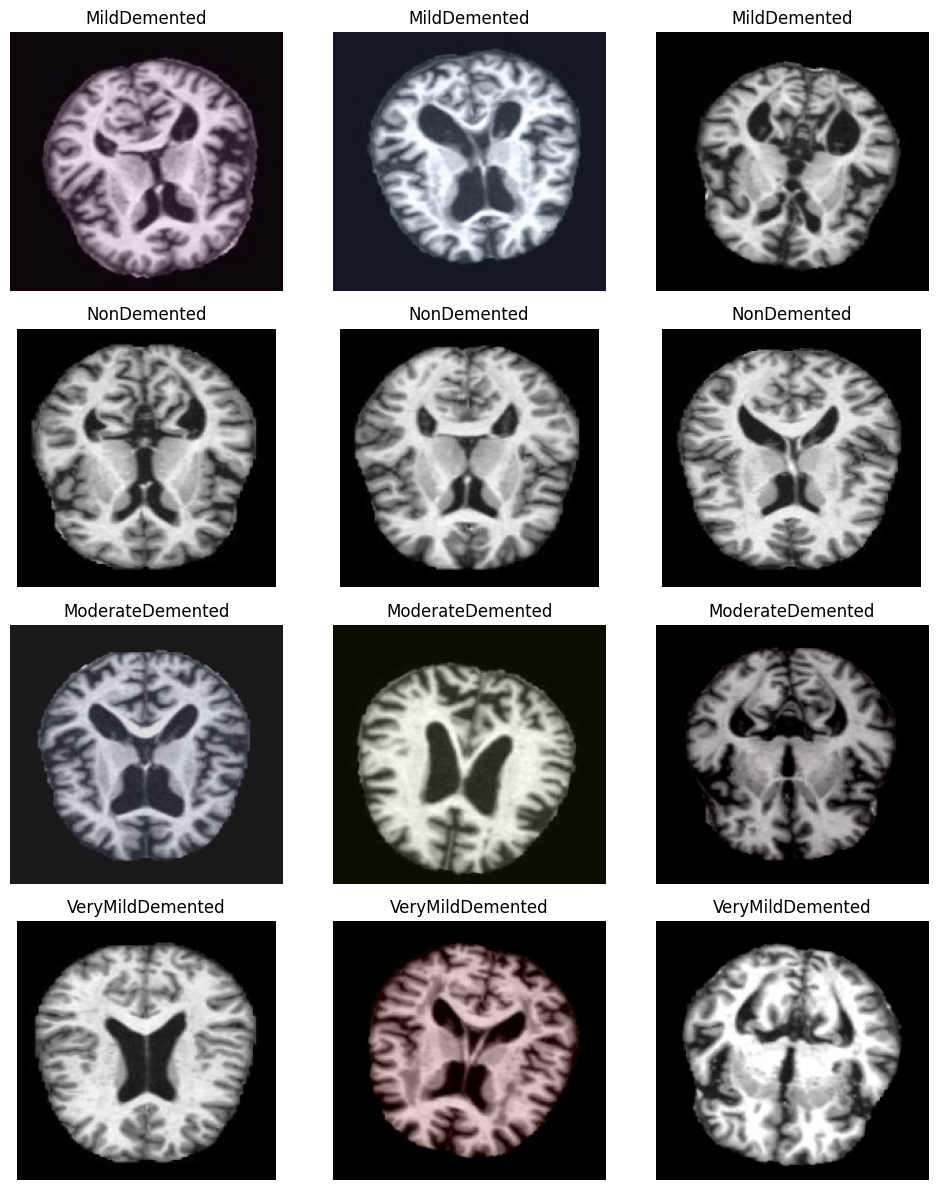

In [15]:
# Jika dataset sudah ada, lewati proses download
if os.path.exists(target_path) and len(os.listdir(target_path)) > 0:
    print(f"✅ Dataset sudah ada di: {target_path}. Lewati proses download.")
else:
    print("⬇️ Mengunduh dataset dari Kaggle...")

    # Download dataset langsung ke folder penyimpanan kagglehub
    dataset_path = kagglehub.dataset_download(kaggle_dataset)
    print("Dataset downloaded at:", dataset_path)

    # Cek isi folder dataset
    subfolders = os.listdir(dataset_path)
    print("Isi folder dataset:", subfolders)

    # Pastikan dataset berada dalam folder yang benar
    if subfolders:
        dataset_main_folder = os.path.join(dataset_path, subfolders[0])  # Ambil folder pertama
    else:
        print("❌ Dataset tidak memiliki folder utama.")
        dataset_main_folder = dataset_path  # Gunakan dataset_path langsung jika tidak ada subfolder

    # Pindahkan dataset ke folder target_path
    shutil.move(dataset_main_folder, target_path)
    print(f"✅ Dataset dipindahkan ke: {target_path}")

# Cari dan tampilkan 3 gambar dari setiap folder dalam dataset
image_extensions = (".png", ".jpg", ".jpeg")
category_images = {}

for category in os.listdir(target_path):
    category_path = os.path.join(target_path, category)
    if os.path.isdir(category_path):
        category_images[category] = [
            os.path.join(category_path, file)
            for file in os.listdir(category_path)
            if file.lower().endswith(image_extensions)
        ][:3]  # Ambil maksimal 3 gambar

# Tampilkan gambar dari setiap kategori
fig, axes = plt.subplots(len(category_images), 3, figsize=(10, 3 * len(category_images)))

for row, (category, images) in enumerate(category_images.items()):
    for col, img_path in enumerate(images):
        img = cv2.imread(img_path)  # Baca gambar
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Ubah dari BGR ke RGB untuk ditampilkan

        axes[row, col].imshow(img)
        axes[row, col].set_title(f"{category}")  # Nama kategori dan file
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()

In [16]:
def analyze_dataset(target_path):
    """
    Counts the number of images in each folder and checks image resolution variations.

    :param target_path: Path to the main dataset folder.
    :return: Dictionary with folder names as keys and values containing image counts and unique resolutions.
    """
    if not os.path.exists(target_path):
        raise FileNotFoundError(f"The directory '{target_path}' does not exist.")

    image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}  # Supported image formats
    folder_analysis = {}

    for folder in os.listdir(target_path):
        folder_path = os.path.join(target_path, folder)
        if os.path.isdir(folder_path):
            image_count = 0
            resolutions = set()

            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if os.path.splitext(file)[1].lower() in image_extensions:
                    img = cv2.imread(file_path)
                    if img is not None:
                        resolutions.add(img.shape[:2])  # (height, width)
                        image_count += 1

            folder_analysis[folder] = {
                "image_count": image_count,
                "unique_resolutions": resolutions
            }

    return folder_analysis

dataset_analysis = analyze_dataset(target_path)

# Menampilkan hasil analisis
for folder, data in dataset_analysis.items():
    print(f"{folder}: {data['image_count']} images, Resolutions: {data['unique_resolutions']}")

# Cek apakah dataset memiliki resolusi yang tidak seragam
dataset_has_variable_resolutions = any(len(data["unique_resolutions"]) > 1 for data in dataset_analysis.values())

if dataset_has_variable_resolutions:
    print("\nDataset memiliki resolusi yang tidak seragam.")
else:
    print("\nDataset memiliki resolusi yang seragam.")

MildDemented: 8960 images, Resolutions: {(180, 180), (190, 200)}
NonDemented: 9600 images, Resolutions: {(180, 180), (190, 200)}
ModerateDemented: 6464 images, Resolutions: {(180, 180), (190, 200)}
VeryMildDemented: 8960 images, Resolutions: {(180, 180), (190, 200)}

Dataset memiliki resolusi yang tidak seragam.


### Split Dataset

Struktur alzheimer_mri_dataset_split dataset
  * train : 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'
  * val : 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'
  * test : 'MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'

In [17]:
# Splitting Ratios
VAL_SPLIT = 0.2  # 20% Validation
TEST_SPLIT = 0.1  # 10% Testing
TRAIN_SPLIT = 1 - (VAL_SPLIT + TEST_SPLIT)  # Remaining 70% for Training

# Define paths
DATASET_PATH = target_path
OUTPUT_DIR = split_dataset

# Create train, val, test folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(OUTPUT_DIR, split), exist_ok=True)

# Loop through each class and distribute images
for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)

    if not os.path.isdir(class_path):
        continue  # Skip non-folder files

    images = os.listdir(class_path)
    random.shuffle(images)  # Shuffle images for randomness

    # Compute split sizes
    total_images = len(images)
    train_size = int(TRAIN_SPLIT * total_images)
    val_size = int(VAL_SPLIT * total_images)

    # Assign images to folders
    for i, img in enumerate(images):
        src_path = os.path.join(class_path, img)

        if i < train_size:
            dst_path = os.path.join(OUTPUT_DIR, "train", class_name)
        elif i < train_size + val_size:
            dst_path = os.path.join(OUTPUT_DIR, "val", class_name)
        else:
            dst_path = os.path.join(OUTPUT_DIR, "test", class_name)

        os.makedirs(dst_path, exist_ok=True)
        shutil.move(src_path, os.path.join(dst_path, img))

    print(f"✅ Processed {class_name}: {total_images} images")

print("✅ Dataset successfully split into train, validation, and test folders!")

✅ Processed MildDemented: 8960 images
✅ Processed NonDemented: 9600 images
✅ Processed ModerateDemented: 6464 images
✅ Processed VeryMildDemented: 8960 images
✅ Dataset successfully split into train, validation, and test folders!


## Data Loading

* Menggunakan image_dataset_from_directory() dengan struktur dataset secara langsung, tanpa perlu manual memisahkan kelas.
* Memastikan dataset memiliki label kelas otomatis dengan train_dataset.class_names.
* Menggunakan tf.data.experimental.cardinality() untuk menghitung jumlah gambar di dataset.
* Menerapkan preprocessing dan augmentasi secara benar, augment hanya untuk training.
* Menerapkan shuffle, batch, dan prefetch setelah preprocessing untuk efisiensi training.

In [18]:
# Define paths
DATASET_PATH = split_dataset
IMG_SIZE = (224, 224)

# Load dataset WITHOUT batch_size (Preprocessing akan menanganinya)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "train"),
    image_size=IMG_SIZE,
    batch_size=None,  # Jangan batch dulu
    shuffle=True,
    seed=42
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "val"),
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=True,
    seed=42
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(DATASET_PATH, "test"),
    image_size=IMG_SIZE,
    batch_size=None,
    shuffle=False  # Jangan shuffle test set
)

# Cek label kelas yang dikenali TensorFlow
# Memastikan dataset memiliki label kelas otomatis
class_names = train_dataset.class_names
print(f"📌 Dataset Labels: {class_names}")

# Check total images using cardinality()
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
val_size = tf.data.experimental.cardinality(val_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

print(f"✅ Dataset Loaded!")
print(f"Train: {train_size} images, Validation: {val_size} images, Test: {test_size} images")

Found 23788 files belonging to 4 classes.
Found 6796 files belonging to 4 classes.
Found 3400 files belonging to 4 classes.
📌 Dataset Labels: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
✅ Dataset Loaded!
Train: 23788 images, Validation: 6796 images, Test: 3400 images


#### Preprocessing Data
1. Resize ke Ukuran Seragam (224x224) agar gambar memiliki dimensi sama untuk diproses CNN.
2. Normalisasi Pixel (ke [0,1] atau [-1,1]). CNN lebih stabil jika nilai pixel dinormalisasi.
3. Shuffle Data, agar model tidak belajar pola berurutan dari data.
4. Batching & Prefetching untuk mempercepat proses loading saat training.

In [19]:
# Define Preprocessing Function (Resize + Normalize + Augmentation for Training)
BATCH_SIZE = 32
BUFFER_SIZE = 1000  # Buffer size for shuffling

# =====================================================
# ✅ PREPROCESSING: Resize, Normalize, and Augment
# =====================================================
def preprocess_image(image, label, augment=False):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]

    # Data Augmentation (hanya untuk training)
    # if augment:
    #     image = tf.image.random_brightness(image, max_delta=0.1)

    return image, label

# ✅ Apply Preprocessing
train_dataset = train_dataset.map(lambda x, y: preprocess_image(x, y, augment=True))
val_dataset = val_dataset.map(preprocess_image)
test_dataset = test_dataset.map(preprocess_image)

# =====================================================
# ✅ Optimisasi: Batch & Prefetch
# =====================================================
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Final Output
print("✅ Dataset is ready for training!")
print(f"Total Images: {train_size + val_size + test_size}")
print(f"Train: {train_size}, Validation: {val_size}, Test: {test_size}")

✅ Dataset is ready for training!
Total Images: 33984
Train: 23788, Validation: 6796, Test: 3400


In [20]:
# Verifikasi ukuran gambar setelah preprocessing
for image, label in train_dataset.take(1):  # Ambil 1 batch pertama
    print(f"📏 Sample Train Image Shape: {image.shape}")  # Seharusnya (batch_size, 224, 224, 3)

for image, label in val_dataset.take(1):  # Ambil 1 batch pertama
    print(f"📏 Sample Validation Image Shape: {image.shape}")  # Seharusnya (batch_size, 224, 224, 3)

for image, label in test_dataset.take(1):  # Ambil 1 batch pertama
    print(f"📏 Sample Test Image Shape: {image.shape}")  # Seharusnya (batch_size, 224, 224, 3)

📏 Sample Train Image Shape: (32, 224, 224, 3)
📏 Sample Validation Image Shape: (32, 224, 224, 3)
📏 Sample Test Image Shape: (32, 224, 224, 3)


## Modelling

Conv2D: Extracts features from MRI images.
MaxPooling2D: Reduces computation and prevents overfitting.
3 Convolution Layers: Deeper networks learn better representations.
Dense(4, activation='softmax'): Outputs 4 class probabilities.
Adam Optimizer: Adaptive learning for stable training.
Sparse Categorical Crossentropy: Used because labels are integers (not one-hot encoded).

In [21]:
# =====================================================
# ✅ CALLBACKS: Early Stopping & Reduce LR
# =====================================================
early_stop_loss = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6
)

# Callback untuk menghentikan training jika val_accuracy >= 95%
early_stop_acc = callbacks.EarlyStopping(
    monitor='val_accuracy',  # Pantau akurasi validasi
    patience=5,              # Tunggu 5 epoch jika belum stabil
    min_delta=0.001,         # Perbedaan minimal untuk dianggap meningkat
    mode='max',              # Karena kita ingin memaksimalkan accuracy
    verbose=1,               # Tampilkan log jika berhenti
    restore_best_weights=True # Kembalikan model ke bobot terbaik
)

# =====================================================
# ✅ MODEL CNN: Sequential API
# =====================================================
model = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(256, (3,3), activation='relu'),  # Bisa dicoba tanpa 512 dulu
    layers.MaxPooling2D(2,2),

    layers.Conv2D(512, (3,3), activation='relu'),  # ✅ Layer tambahan 512
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Mengurangi overfitting
    layers.Dense(4, activation='softmax')
])

# =====================================================
# ✅ KOMPILE MODEL
# =====================================================
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# =====================================================
# ✅ TRAINING MODEL
# =====================================================
EPOCHS = 50

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,  # Bisa set besar, karena EarlyStopping akan menghentikan lebih awal
    callbacks=[early_stop_acc, early_stop_loss, reduce_lr]  # Tambahkan callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 66s 74ms/step - accuracy: 0.3270 - loss: 3.1843 - val_accuracy: 0.5564 - val_loss: 0.9882 - learning_rate: 0.0010
Epoch 2/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 67s 65ms/step - accuracy: 0.5173 - loss: 0.9998 - val_accuracy: 0.6551 - val_loss: 0.7395 - learning_rate: 0.0010
Epoch 3/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 87s 71ms/step - accuracy: 0.5857 - loss: 0.8566 - val_accuracy: 0.6964 - val_loss: 0.6698 - learning_rate: 0.0010
Epoch 4/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 54s 71ms/step - accuracy: 0.6176 - loss: 0.8179 - val_accuracy: 0.7347 - val_loss: 0.5901 - learning_rate: 0.0010
Epoch 5/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 79s 67ms/step - accuracy: 0.6661 - loss: 0.7277 - val_accuracy: 0.7588 - val_loss: 0.5505 - learning_rate: 0.0010
Epoch 6/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.6996 - loss: 0.6662 - val_accuracy: 0.7815 - val_loss: 0.4885 - learning_rate: 0.0010
Epoch 7/50
744/744 ━━━━━━━━━━━━━━━━━━━━ 87s 71ms/step - accuracy: 0.7247 - l

* Tambahkan Batch Normalization untuk stabilisasi training
* Eksperimen dengan Dropout Rate (misalnya: 0.3 atau 0.4)
* Pastikan dataset memiliki variasi cukup untuk menghindari bias


## Evaluasi dan Visualisasi

107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9436 - loss: 0.1586
Test Accuracy: 0.9200, Test Loss: 0.2494


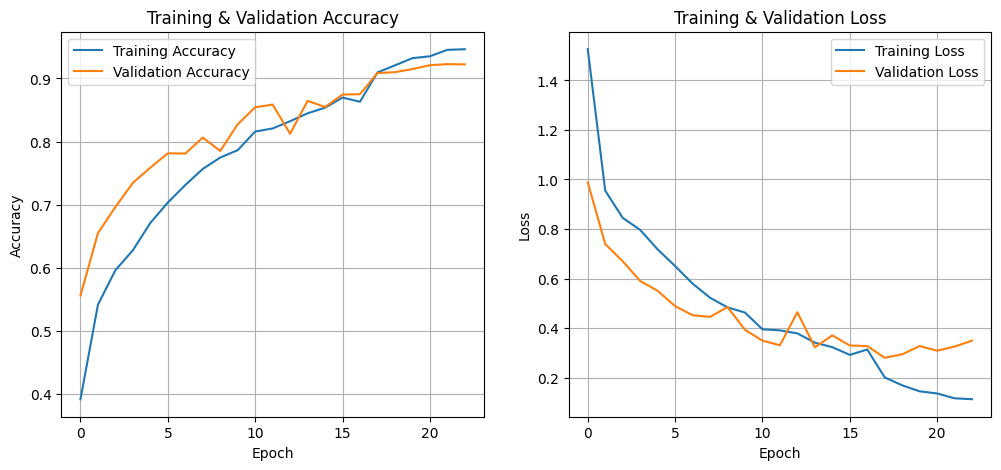

In [22]:
# =====================================================
# ✅ EVALUASI MODEL
# =====================================================
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")

# =====================================================
# ✅ PLOT AKURASI & LOSS
# =====================================================
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plot Akurasi
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title('Training & Validation Accuracy')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')
    plt.grid(True)
    plt.show()

# Pastikan history ada sebelum memanggil fungsi
if 'history' in locals():
    plot_history(history)
else:
    print("History belum tersedia. Pastikan model telah dilatih.")

## Konversi Model

In [23]:
# =====================================================
# ✅ SIMPAN MODEL DALAM FORMAT SavedModel, TF-Lite, & TFJS
# =====================================================

# Simpan sebagai Keras Native Format (.keras) → Disarankan untuk penyimpanan umum
model.save("alzheimer_model_native.keras")

# Simpan sebagai SavedModel (untuk TFLite dan TFServing)
model.export("alzheimer_model/TFLite_TFServing")

# Simpan sebagai TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("alzheimer_model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan sebagai TensorFlow.js
tfjs.converters.save_keras_model(model, "alzheimer_model/tfjs_model")

Saved artifact at 'alzheimer_model/TFLite_TFServing'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140408380340368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408380341904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361239952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361240528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361240912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361238608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361238992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361239568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361240144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140408361242640: TensorSpec(shape=(), dtype=tf.resource, name=None)


failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

Saving yuhu.jpg to yuhu.jpg


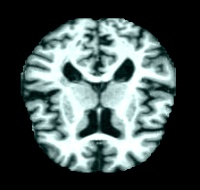


🔍 **Prediksi:** NonDemented (100.00%)



In [33]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display
from PIL import Image

# =====================================================
# ✅ LOAD MODEL
# =====================================================
MODEL_PATH = "alzheimer_model_native.keras"
model = tf.keras.models.load_model(MODEL_PATH)

# Kelas sesuai dengan dataset
CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# =====================================================
# ✅ GUNAKAN PREPROCESS_IMAGE DARI TRAINING
# =====================================================
def preprocess_image(image):
    """ Preprocessing gambar agar sesuai dengan training pipeline """
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalisasi ke [0,1]
    return image

# =====================================================
# ✅ PREDIKSI GAMBAR (Menggunakan Preprocessing dari Training)
# =====================================================
def predict_image(image_path):
    # 1️⃣ Load gambar dan konversi ke RGB
    image = Image.open(image_path).convert('RGB')
    image = image.resize((224, 224))  # Resize agar sesuai dengan input model

    # 2️⃣ Konversi ke Tensor
    image = tf.keras.preprocessing.image.img_to_array(image)  # Konversi ke array
    image = preprocess_image(image)  # Gunakan preprocessing yang sama
    image = tf.expand_dims(image, axis=0)  # Tambahkan batch dimension

    # 3️⃣ Prediksi dengan model
    predictions = model(image, training=False)  # Pastikan dalam mode inference
    predicted_class = CLASS_NAMES[tf.argmax(predictions, axis=-1).numpy()[0]]
    confidence = tf.reduce_max(predictions).numpy() * 100  # Convert ke persen

    return predicted_class, confidence

# =====================================================
# ✅ UPLOAD GAMBAR & PREDIKSI
# =====================================================
uploaded = files.upload()

for file_name in uploaded.keys():
    # Tampilkan gambar
    image = Image.open(file_name)
    display(image)

    # Prediksi
    predicted_class, confidence = predict_image(file_name)

    # Tampilkan hasil prediksi
    print(f"\n🔍 **Prediksi:** {predicted_class} ({confidence:.2f}%)\n")
